In [1]:
import sys
import os
sys.path.append("../src/whole_history_rating")
from whr import whole_history_rating
from whr import utils
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from scipy.optimize import curve_fit

In [2]:
data_path = '../data/cfbd/games_1990_to_2020.csv'

In [3]:
games_df = pd.read_csv(data_path)
games_df_test = games_df[games_df.season<2015]
games_df_verify = games_df[games_df.season>=2015]
games_df.shape

(23256, 25)

In [4]:
datetime_from_cfbd = lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ")
mean_and_error = lambda x: (np.mean(x), np.std(x)/len(x))
abeError = lambda x: mean_and_error(np.abs(x))

In [28]:

def benchmark_w2(df, default_w2, verbose=False, time_offset=300, max_events=-1,popt=[]):
    n_games = games_df_test.shape[0]
    n_iter_games = 0
    n_pred_games = 0
    correct_prediction_list = []
    delta_mov_list = []
    pred_list = []
    mov_list = []
    
    scale = 13
    mov_SF = 13/scale
    whr = whole_history_rating.Base({'scale': scale,'w2':default_w2, 'debug':False})
    start_time = 0
    home_team_handicap = 2.5/13*scale
    current_day,day_delta=0,0
    
    for i,row in df.iterrows():
        game_time = datetime_from_cfbd(row.start_date)
        if start_time == 0: start_time = game_time
        day_delta = (game_time-start_time).days
        
        n_iter_games+=1
        
        if current_day!=day_delta: 
            #clear_output(wait=True)
            percent_done = (.0+n_iter_games)/n_games*100
            #display(n_pred_games)
            #display("new day: {}, {:.1f}% done".format(day_delta, percent_done ))
            #if len(correct_prediction_list)>0: display("correct: {:.1f}%".format(np.mean(correct_prediction_list)*100 ))
            #if len(delta_mov_list)>0: display("abe: {:.2f}".format( abeError(delta_mov_list)[0] ) )
            whr.auto_iterate(time_limit = 10, precision = 10E-4*scale/400)
            current_day=day_delta

        home_team = row.home_team
        away_team = row.away_team
        handicap = -(1-row.neutral_site)*home_team_handicap
        mov = row.home_points-row.away_points
        winner = "W" if mov>0 else "B"
        if mov==0: continue
        home_w_prob,away_w_prob = whr.probability_future_match(home_team,away_team,-handicap, verbose=False)
        home_rating,home_unc = whr.ratings_for_player(home_team,current=True)
        away_rating,away_unc = whr.ratings_for_player(away_team,current=True)
        
        if home_rating and away_rating:
            predicted_mov = (home_rating-away_rating+handicap)*mov_SF
            if len(popt): predicted_mov = linear_func(predicted_mov,*popt)
            n_pred_games+=1
        else:
            predicted_mov = None
            
        correct_prediction = (home_w_prob-away_w_prob)*mov>0
        if time_offset < day_delta: 
            correct_prediction_list.append(correct_prediction)
            if predicted_mov: 
                delta_mov_list.append(mov-predicted_mov)
                pred_list.append(predicted_mov)
                mov_list.append(mov)
            
        if verbose: 
            print("\t away team: {}, home team: {}".format(away_team,home_team))
            print("\t winner: {} (W is home), days: {} handicap: {}".format(winner,day_delta,handicap))
            print("\t {} win: {:.2f}%, predicted spread: {}, actual spread: {}".format(home_team,home_w_prob*100,predicted_mov, mov))
            print("\t day_delta: {} correct prediction: {}".format(day_delta,correct_prediction))
            print(home_w_prob,away_w_prob)
            print(home_rating,away_rating)
        if time_offset < day_delta:
            whr.create_game(away_team,home_team,winner, day_delta, handicap)
        
        if max_events > 0: 
            if n_pred_games > max_events: break
    return correct_prediction_list,pred_list,mov_list

In [73]:
start = time.perf_counter()
w2_list = []
per_corr_list = []
per_corr_unc_list = []
abe_list = []
abe_unc_list = []
mov_list_list = []
pred_mov_list_list = []
log_min, log_max = 2.6, 3.1
log_space = np.logspace(log_min, log_max,10)
lin_space = np.linspace(log_min, log_max,10)

popt = [1.05553551, 6.18054934]

for w2,w2_power in zip(log_space,lin_space):
    print("w2 value: {}, w2 power: {}".format(w2, w2_power))
    correct_prediction_list,pred_list,mov_list = benchmark_w2(games_df,w2,time_offset=8902,max_events=1000,popt=popt)
    mov_list,pred_list = np.asarray(mov_list),np.asarray(pred_list)
    mov_list_list.append(mov_list)
    pred_mov_list_list.append(pred_list)
    percent_corr,percent_corr_unc  = mean_and_error(correct_prediction_list)
    abe_error,abe_error_unc = abeError(mov_list-pred_list)
    w2_list.append(w2)
    per_corr_list.append(percent_corr)
    per_corr_unc_list.append(percent_corr_unc)
    abe_list.append(abe_error)
    abe_unc_list.append(abe_error_unc)
    mid_time = time.perf_counter()
    print("{:.2f}% corr, abe error: {:.2f}".format(percent_corr*100,abe_error))
    print("{:.2f} seconds elapsed".format(mid_time-start))
end = time.perf_counter()
end-start

w2 value: 398.1071705534973, w2 power: 2.6
70.37% corr, abe error: 15.67
161.26 seconds elapsed
w2 value: 452.4343346616744, w2 power: 2.6555555555555554
69.99% corr, abe error: 15.77
317.10 seconds elapsed
w2 value: 514.1751827683928, w2 power: 2.7111111111111112
69.98% corr, abe error: 15.74
470.27 seconds elapsed
w2 value: 584.3414133735175, w2 power: 2.7666666666666666
70.27% corr, abe error: 15.74
633.68 seconds elapsed
w2 value: 664.0827850634845, w2 power: 2.8222222222222224
70.26% corr, abe error: 15.62
785.45 seconds elapsed
w2 value: 754.7059566968904, w2 power: 2.8777777777777778
70.20% corr, abe error: 15.69
940.03 seconds elapsed
w2 value: 857.6958985908946, w2 power: 2.9333333333333336
69.98% corr, abe error: 15.68
1094.12 seconds elapsed
w2 value: 974.7402255566063, w2 power: 2.988888888888889
69.77% corr, abe error: 15.71
1250.35 seconds elapsed
w2 value: 1107.7568505097088, w2 power: 3.0444444444444443
69.59% corr, abe error: 15.74
1427.55 seconds elapsed
w2 value: 125

1609.7825565469975

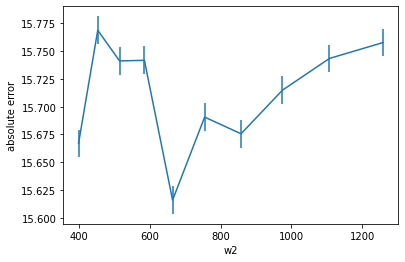

In [74]:
plt.errorbar(w2_list,abe_list,yerr=abe_unc_list)
plt.ylabel("absolute error")
plt.xlabel("w2")
plt.savefig("abe_v_w2_{}_to_{}.png".format(log_min, log_max))

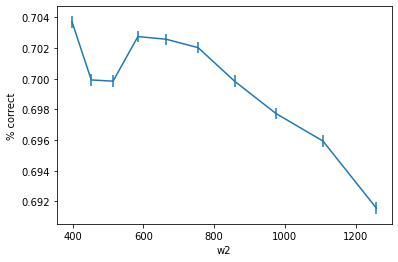

In [75]:
plt.errorbar(w2_list,per_corr_list,yerr=per_corr_unc_list)
plt.ylabel("% correct")
plt.xlabel("w2")
plt.savefig("percent_corr_v_w2_{}_to_{}.png".format(log_min, log_max))

In [76]:
def linear_func(x,m,b):
    return m * x + b

In [77]:
x,y = pred_mov_list_list[5],mov_list_list[5]
popt,pcov = curve_fit(linear_func,x,y)
popt, pcov

(array([1.13675681, 1.49557498]),
 array([[ 0.00360343, -0.01815795],
        [-0.01815795,  0.48608336]]))

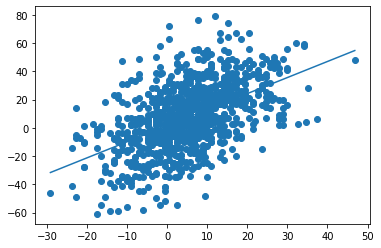

In [78]:
x_space = np.linspace(np.min(x), np.max(x),100)
y_pred = linear_func(x_space,*popt)
plt.scatter(x,y)
plt.plot(x_space,y_pred)

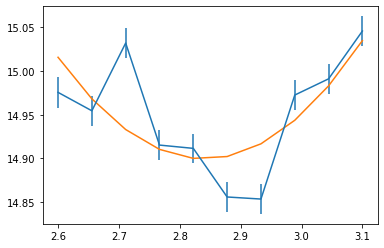

In [67]:
abes = []
abes_unc = []
for x,y, exp in zip(pred_mov_list_list,mov_list_list,lin_space):
    popt,pcov = curve_fit(linear_func,x,y)
    popt, pcov
    y_scaled = linear_func(x,*popt)
    abe,abe_unc = (abeError(y_scaled-y))
    abes.append(abe)
    abes_unc.append(abe_unc)
    
space = lin_space
plt.errorbar(space,abes,yerr=abes_unc)

def quadratic_func(x,a,b,c):
    return a * x **2 + b * x + c

popt,pconv = curve_fit(quadratic_func,space,abes)

y_pred = quadratic_func(space,*popt)
plt.plot(space,y_pred)

array([ 7.16020905e-07, -1.11718554e-03,  1.53323731e+01])

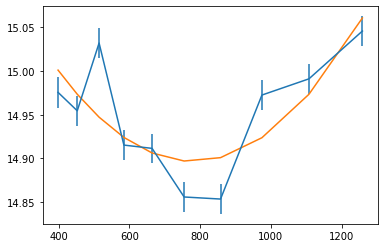

In [69]:
space = log_space
plt.errorbar(space,abes,yerr=abes_unc)

def quadratic_func(x,a,b,c):
    return a * x **2 + b * x + c

popt,pconv = curve_fit(quadratic_func,space,abes)

y_pred = quadratic_func(space,*popt)
plt.plot(space,y_pred)

popt

In [ ]:
max_events = [100,300,500]
total_time = [13.94,174,326.60867288500594]
plt.plot(max_events,total_time)

In [78]:
start_time=0
for i,row in games_df_test.iterrows():
        game_time = datetime_from_cfbd(row.start_date)
        if start_time == 0: start_time = game_time
        day_delta = (game_time-start_time).days
day_delta, day_delta/games_df_test.shape[0]

(8905, 0.4866386141319198)

In [79]:
.4866386141319198*1000

486.6386141319198

In [38]:
np.logspace(2.6, 3.1,10)

array([ 398.10717055,  452.43433466,  514.17518277,  584.34141337,
        664.08278506,  754.7059567 ,  857.69589859,  974.74022556,
       1107.75685051, 1258.92541179])